In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import pandas as pd
import os
import sys
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
from spaotsc import SpaOTsc
from scipy import stats

In [103]:
## pos_CN1.csv from Xiaonan
## spt_4U_p2MaskCNR1_S2CellGeneExp.txt from Xiaonan
## LigRec_secreted_mouseN_fixed.txt from Xiaonan
pts_CN = np.loadtxt("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/pos_CN1.csv", delimiter=',')
dmat_is_CN = distance_matrix(pts_CN, pts_CN)

df_is_CN = pd.read_csv('/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2MaskCNR1_S2CellGeneExp.txt', index_col=0)

genes_measured = np.array(df_is_CN.columns.values, dtype=str )
ligrec_pairs_tmp = np.loadtxt( "/media/gulab/GUDR2/PB10_new/LigRec_secreted_mouseN_fixed.txt", dtype=str)



ligrec_pairs_is = []
for i in range(len(ligrec_pairs_tmp)):
    if ligrec_pairs_tmp[i,0] in genes_measured and ligrec_pairs_tmp[i,1] in genes_measured:
        ligrec_pairs_is.append([ligrec_pairs_tmp[i,0], ligrec_pairs_tmp[i,1]])

print("Number of lig-rec pairs in pixel-seq data: ", len(ligrec_pairs_is))

ligs = []
for [lig, rec] in ligrec_pairs_is:
    if not lig in ligs:
        ligs.append(lig)
        
recs = {}
for lig in ligs:
    recs_tmp = []
    for i in range(len(ligrec_pairs_is)):
        if ligrec_pairs_is[i][0] == lig:
            recs_tmp.append(ligrec_pairs_is[i][1])
    recs[lig] = recs_tmp
    
lig_families = ['A2m','Adcyap','Adipoq','Adm','Agrp','Agt','Ahsg','Alb','Amelx','Amh','Angptl','Anxa','Apln','Apob','Apod','Apoe','Artn','Avp','Azgp','Bag6','Bcan','Bdnf','Bgn','Bmp'
,'C1qa','C1qb','C1qtnf','C3','C4','Hc','2300002M23Rik','Calca','Calcb','Camp','Cck','Ccl',
'Cd','Cela3b','Cel','Cfh','Cga','Chad','Clcf','Clec','Cntn','Col','Cort','Cp',
'Crh','Crp','Csf','Gh','Ctf','Cthrc','Cxcl','Cx3cl','Dcn','Dhh','Dkk','Ebi','Ecm','Edil','Edn','Efemp','Efna','Endo','Epo','Fbln','Fbn','Fga','Fgb','Fgf',
'Fgg','Fgl','Fn','Fshb','Fst','Galp','Gal','Gas','Gast','Gdf','Gdnf','Ghrh','Ghrl',
'Gip','Gnrh','Gpha','Grem','Grp','Grn','Guca','Hbegf','Hcrt','Hgf','Hhipl','Hp','Hspg','Iapp','Ibsp','Ifn','Igfbp','Ihh','Il','Inha','Inhb',
'Insl','Ins2','Itih','Kiss','Klk','Kng','Lam','Lcn','Lefty','Lep','Lgals','Lhb','Lif','Lipc','Liph','Lpl','Lta','Ltbp','Ltf','Ly86','Lyz','Matn','Mbl','Mdk','Mepe',
'Mfap','Mfge','Mia','Mif','Mmp','Mst1','Mstn','Myoc','Nampt','Ncan','Ndp','Ngf',
'Nid','Nmb','Nms','Nmu','Nodal','Npb','Npff','Npnt','Npp','Nps','Npvf','Npw','Npy','Nrtn','Ntf','Ntn','Nts','Nucb','Nxph','Olfm','Osm','Ostn','Oxt',
'P4hb','Papln','Pcsk9','Pdgf','Pdyn','Penk','Pf4','Pgf','Pip','Pla','Plg','Pltp','Pmch','Pnoc','Pomc','Pon2','Ppy','Prlh','Prl','Proc','Prok','Prss','Pspn','Psap',
'Pth','Ptn','Pyy','Qrfp','Rarres','Rbp','Reln','Ren','Rgma','Rln','Rnase2a','Rspo','S100','Saa','Scgb','Sema','Serpin','Sfrp','Sftp','Shbg','Slit','Slpi','Sost','Spink','Spon2','Spp1','Sst','Tac',
'Tcn','Tdgf','Tfpi','Trf','Tgfb','Tg','Thbs','Thpo','Timp','Tnc','Tnfsf','Trh','Tshb','Tslp','Ucn','Uts','Vcan','Vegf','Vip','Vtn','Vwf','Wnt','Xcl1','F','Hc','Igf','Angpt','Tnf']
               

lig_family_members = {}
for lig_family in lig_families:
    lig_list_tmp = []
    for lig in ligs:
        if lig[:len(lig_family)] == lig_family:
            lig_list_tmp.append(lig)
            ligs.remove(lig)
    lig_family_members[lig_family] = lig_list_tmp
    
df_is_normalized_CN = pd.DataFrame(data=np.log(1+np.array(df_is_CN.values)), columns=df_is_CN.columns.values)

## S2umap_CNR1_cluster.csv from Xiaonan
cluster_id_CN = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_CNR1_cluster.csv", dtype=int)
ics_CN = list(set(cluster_id_CN))

issc_CN = SpaOTsc.spatial_sc(sc_data=df_is_normalized_CN)
issc_CN.cell_cell_distance(sc_dmat_spatial=dmat_is_CN/dmat_is_CN.max())
S_CN = np.zeros_like(dmat_is_CN)
S_lig_weights_CN = []
S_weighted_CN = np.zeros_like(dmat_is_CN)
ligs = []
for lig_family in lig_families:
    S_family_CN = np.zeros_like(dmat_is_CN)
    cnt_CN = 0.0
    for lig in lig_family_members[lig_family]:
        if np.max(issc_CN.sc_data[lig]) >= 1.0 and np.max(np.sum(issc_CN.sc_data[recs[lig]], axis=0)) >= 1.0:
            S_tmp_CN = issc_CN.spatial_signaling_ot([lig], recs[lig])
            S_family_CN += S_tmp_CN
            cnt_CN += 1.0
            a_CN,b_CN = issc_CN.spatial_signaling_ot([lig], recs[lig], return_weight_only=True)
            S_lig_weights_CN.append( min(a_CN, b_CN) )
            S_weighted_CN += issc_CN.spatial_signaling_ot([lig], recs[lig]) * min(a_CN, b_CN)
        else:
            S_lig_weights_CN.append(0.0)
        ligs.append(lig)
    if cnt_CN > 0:
        S_family_CN = S_family_CN/cnt_CN
    S_CN += S_family_CN

Number of lig-rec pairs in pixel-seq data:  1357


In [3]:
## S2umap_CNR1_cluster.csv from Xiaonan
cluster_id = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_CNR1_cluster.csv", dtype=int)
ics = list(set(cluster_id))

S_cluster = np.empty( [28, 28], float )

for i in range(28):
    for j in range(28):
        icid = np.where(cluster_id==ics[i])[0]
        jcid = np.where(cluster_id==ics[j])[0]
        S_cluster[i,j] = np.mean(S_CN[icid,:][:,jcid])

np.savetxt("/media/gulab/GUDR2/PB10_new/CNR1_29cluster.mtx", S_cluster)
np.save( "/media/gulab/GUDR2/PB10_new/S_CN.npy", S_CN)
fig, ax = plt.subplots(figsize=(10, 10))
pos = ax.imshow(S_cluster)
fig.colorbar(pos, ax=ax)
plt.show()

NameError: name 'S_CN' is not defined

In [4]:
S_CN = np.load("/media/gulab/GUDR2/PB10_new/S_CN.npy")
L = np.sum(S_CN, axis=1); R = np.sum(S_CN, axis=0)
fileobj1 = open('/media/gulab/GUDR2/PB10_new/CNR1_29cluster_sender.csv', mode='wb')
L.tofile(fileobj1,sep="\n")

In [2]:
## pos_30d1.csv from Xiaonan
## spt_4U_p2Mask30d1_S2CellGeneExp.txt from Xiaonan
## LigRec_secreted_mouseN_fixed.txt from Xiaonan
pts_TR = np.loadtxt("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/pos_30d1.csv", delimiter=',')
dmat_is_TR = distance_matrix(pts_TR, pts_TR)

df_is_TR = pd.read_csv('/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2Mask30d1_S2CellGeneExp.txt', index_col=0)

genes_measured = np.array(df_is_TR.columns.values, dtype=str )
ligrec_pairs_tmp = np.loadtxt( "/media/gulab/GUDR2/PB10_new/LigRec_secreted_mouseN_fixed.txt", dtype=str)

ligrec_pairs_is = []
for i in range(len(ligrec_pairs_tmp)):
    if ligrec_pairs_tmp[i,0] in genes_measured and ligrec_pairs_tmp[i,1] in genes_measured:
        ligrec_pairs_is.append([ligrec_pairs_tmp[i,0], ligrec_pairs_tmp[i,1]])

print("Number of lig-rec pairs in pixel-seq data: ", len(ligrec_pairs_is))

ligs = []
for [lig, rec] in ligrec_pairs_is:
    if not lig in ligs:
        ligs.append(lig)
        
recs = {}
for lig in ligs:
    recs_tmp = []
    for i in range(len(ligrec_pairs_is)):
        if ligrec_pairs_is[i][0] == lig:
            recs_tmp.append(ligrec_pairs_is[i][1])
    recs[lig] = recs_tmp
    
lig_families = ['A2m','Adcyap','Adipoq','Adm','Agrp','Agt','Ahsg','Alb','Amelx','Amh','Angptl','Anxa','Apln','Apob','Apod','Apoe','Artn','Avp','Azgp','Bag6','Bcan','Bdnf','Bgn','Bmp'
,'C1qa','C1qb','C1qtnf','C3','C4','Hc','2300002M23Rik','Calca','Calcb','Camp','Cck','Ccl',
'Cd','Cela3b','Cel','Cfh','Cga','Chad','Clcf','Clec','Cntn','Col','Cort','Cp',
'Crh','Crp','Csf','Gh','Ctf','Cthrc','Cxcl','Cx3cl','Dcn','Dhh','Dkk','Ebi','Ecm','Edil','Edn','Efemp','Efna','Endo','Epo','Fbln','Fbn','Fga','Fgb','Fgf',
'Fgg','Fgl','Fn','Fshb','Fst','Galp','Gal','Gas','Gast','Gdf','Gdnf','Ghrh','Ghrl',
'Gip','Gnrh','Gpha','Grem','Grp','Grn','Guca','Hbegf','Hcrt','Hgf','Hhipl','Hp','Hspg','Iapp','Ibsp','Ifn','Igfbp','Ihh','Il','Inha','Inhb',
'Insl','Ins2','Itih','Kiss','Klk','Kng','Lam','Lcn','Lefty','Lep','Lgals','Lhb','Lif','Lipc','Liph','Lpl','Lta','Ltbp','Ltf','Ly86','Lyz','Matn','Mbl','Mdk','Mepe',
'Mfap','Mfge','Mia','Mif','Mmp','Mst1','Mstn','Myoc','Nampt','Ncan','Ndp','Ngf',
'Nid','Nmb','Nms','Nmu','Nodal','Npb','Npff','Npnt','Npp','Nps','Npvf','Npw','Npy','Nrtn','Ntf','Ntn','Nts','Nucb','Nxph','Olfm','Osm','Ostn','Oxt',
'P4hb','Papln','Pcsk9','Pdgf','Pdyn','Penk','Pf4','Pgf','Pip','Pla','Plg','Pltp','Pmch','Pnoc','Pomc','Pon2','Ppy','Prlh','Prl','Proc','Prok','Prss','Pspn','Psap',
'Pth','Ptn','Pyy','Qrfp','Rarres','Rbp','Reln','Ren','Rgma','Rln','Rnase2a','Rspo','S100','Saa','Scgb','Sema','Serpin','Sfrp','Sftp','Shbg','Slit','Slpi','Sost','Spink','Spon2','Spp1','Sst','Tac',
'Tcn','Tdgf','Tfpi','Trf','Tgfb','Tg','Thbs','Thpo','Timp','Tnc','Tnfsf','Trh','Tshb','Tslp','Ucn','Uts','Vcan','Vegf','Vip','Vtn','Vwf','Wnt','Xcl1','F','Hc','Igf','Angpt','Tnf']
               

lig_family_members = {}
for lig_family in lig_families:
    lig_list_tmp = []
    for lig in ligs:
        if lig[:len(lig_family)] == lig_family:
            lig_list_tmp.append(lig)
            ligs.remove(lig)
    lig_family_members[lig_family] = lig_list_tmp
    
df_is_normalized_TR = pd.DataFrame(data=np.log(1+np.array(df_is_TR.values)), columns=df_is_TR.columns.values)

## S2umap_30d1_cluster.csv from Xiaonan
cluster_id_TR = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_30d1_cluster.csv", dtype=int)
ics_TR = list(set(cluster_id_TR))

issc_TR = SpaOTsc.spatial_sc(sc_data=df_is_normalized_TR)
issc_TR.cell_cell_distance(sc_dmat_spatial=dmat_is_TR/dmat_is_TR.max())
S_TR = np.zeros_like(dmat_is_TR)
S_lig_weights_TR = []
S_weighted_TR = np.zeros_like(dmat_is_TR)
ligs = []
for lig_family in lig_families:
    S_family_TR = np.zeros_like(dmat_is_TR)
    cnt_TR = 0.0
    for lig in lig_family_members[lig_family]:
        if np.max(issc_TR.sc_data[lig]) >= 1.0 and np.max(np.sum(issc_TR.sc_data[recs[lig]], axis=0)) >= 1.0: 
            S_tmp_TR = issc_TR.spatial_signaling_ot([lig], recs[lig])
            S_family_TR += S_tmp_TR
            cnt_TR += 1.0
            a_TR,b_TR = issc_TR.spatial_signaling_ot([lig], recs[lig], return_weight_only=True)
            S_lig_weights_TR.append( min(a_TR, b_TR) )
            S_weighted_TR += issc_TR.spatial_signaling_ot([lig], recs[lig]) * min(a_TR, b_TR)
        else:
            S_lig_weights_TR.append(0.0)
        ligs.append(lig)
    if cnt_TR > 0:
        S_family_TR = S_family_TR/cnt_TR

        S_TR += S_family_TR

Number of lig-rec pairs in pixel-seq data:  1357


In [6]:
cluster_id = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_CNR1_cluster.csv", dtype=int)
cluster_id_30 = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_30d1_cluster.csv", dtype=int)

In [11]:
cluster_id_30 = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_30d1_cluster.csv", dtype=int)
ics_30 = list(set(cluster_id_30))

S_cluster_30 = np.empty( [28, 28], float )

for i in range(28):
    for j in range(28):
        icid_30 = np.where(cluster_id_30==ics_30[i])[0]
        jcid_30 = np.where(cluster_id_30==ics_30[j])[0]
        S_cluster_30[i,j] = np.mean(S_TR[icid_30,:][:,jcid_30])
        
np.savetxt("/media/gulab/GUDR2/PB10_new/CNR1_29cluster.mtx", S_cluster_30)
np.save( "/media/gulab/GUDR2/PB10_new/S_TR.npy", S_TR)
fig, ax = plt.subplots(figsize=(10, 10))
pos = ax.imshow(S_cluster_30)
fig.colorbar(pos, ax=ax)
plt.show()

In [5]:
S_TR = np.load("/media/gulab/GUDR2/PB10_new/S_TR.npy")
L = np.sum(S_TR, axis=1); R = np.sum(S_TR, axis=0)
fileobj1 = open('/media/gulab/GUDR2/PB10_new/30d1_29cluster_sender.csv', mode='wb')
L.tofile(fileobj1,sep="\n")

## Ks-test for all pairs of clusters

In [ ]:
pts_CN = np.loadtxt("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/pos_CN1.csv", delimiter=',')
dmat_is_CN = distance_matrix(pts_CN, pts_CN)

pts_TR = np.loadtxt("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/pos_30d1.csv", delimiter=',')
dmat_is_TR = distance_matrix(pts_TR, pts_TR)

df_is_CN = pd.read_csv('/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2MaskCNR1_S2CellGeneExp.txt', index_col=0)
df_is_TR = pd.read_csv('/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2Mask30d1_S2CellGeneExp.txt', index_col=0)

genes_measured = np.array(df_is_CN.columns.values, dtype=str )
ligrec_pairs_tmp = np.loadtxt( "/media/gulab/GUDR2/PB10_new/LigRec_secreted_mouseN_fixed.txt", dtype=str)



ligrec_pairs_is = []
for i in range(len(ligrec_pairs_tmp)):
    if ligrec_pairs_tmp[i,0] in genes_measured and ligrec_pairs_tmp[i,1] in genes_measured:
        ligrec_pairs_is.append([ligrec_pairs_tmp[i,0], ligrec_pairs_tmp[i,1]])

print("Number of lig-rec pairs in pixel-seq data: ", len(ligrec_pairs_is))

ligs = []
for [lig, rec] in ligrec_pairs_is:
    if not lig in ligs:
        ligs.append(lig)
        
recs = {}
for lig in ligs:
    recs_tmp = []
    for i in range(len(ligrec_pairs_is)):
        if ligrec_pairs_is[i][0] == lig:
            recs_tmp.append(ligrec_pairs_is[i][1])
    recs[lig] = recs_tmp
    
lig_families = ['A2m','Adcyap','Adipoq','Adm','Agrp','Agt','Ahsg','Alb','Amelx','Amh','Angptl','Anxa','Apln','Apob','Apod','Apoe','Artn','Avp','Azgp','Bag6','Bcan','Bdnf','Bgn','Bmp'
,'C1qa','C1qb','C1qtnf','C3','C4','Hc','2300002M23Rik','Calca','Calcb','Camp','Cck','Ccl',
'Cd','Cela3b','Cel','Cfh','Cga','Chad','Clcf','Clec','Cntn','Col','Cort','Cp',
'Crh','Crp','Csf','Gh','Ctf','Cthrc','Cxcl','Cx3cl','Dcn','Dhh','Dkk','Ebi','Ecm','Edil','Edn','Efemp','Efna','Endo','Epo','Fbln','Fbn','Fga','Fgb','Fgf',
'Fgg','Fgl','Fn','Fshb','Fst','Galp','Gal','Gas','Gast','Gdf','Gdnf','Ghrh','Ghrl',
'Gip','Gnrh','Gpha','Grem','Grp','Grn','Guca','Hbegf','Hcrt','Hgf','Hhipl','Hp','Hspg','Iapp','Ibsp','Ifn','Igfbp','Ihh','Il','Inha','Inhb',
'Insl','Ins2','Itih','Kiss','Klk','Kng','Lam','Lcn','Lefty','Lep','Lgals','Lhb','Lif','Lipc','Liph','Lpl','Lta','Ltbp','Ltf','Ly86','Lyz','Matn','Mbl','Mdk','Mepe',
'Mfap','Mfge','Mia','Mif','Mmp','Mst1','Mstn','Myoc','Nampt','Ncan','Ndp','Ngf',
'Nid','Nmb','Nms','Nmu','Nodal','Npb','Npff','Npnt','Npp','Nps','Npvf','Npw','Npy','Nrtn','Ntf','Ntn','Nts','Nucb','Nxph','Olfm','Osm','Ostn','Oxt',
'P4hb','Papln','Pcsk9','Pdgf','Pdyn','Penk','Pf4','Pgf','Pip','Pla','Plg','Pltp','Pmch','Pnoc','Pomc','Pon2','Ppy','Prlh','Prl','Proc','Prok','Prss','Pspn','Psap',
'Pth','Ptn','Pyy','Qrfp','Rarres','Rbp','Reln','Ren','Rgma','Rln','Rnase2a','Rspo','S100','Saa','Scgb','Sema','Serpin','Sfrp','Sftp','Shbg','Slit','Slpi','Sost','Spink','Spon2','Spp1','Sst','Tac',
'Tcn','Tdgf','Tfpi','Trf','Tgfb','Tg','Thbs','Thpo','Timp','Tnc','Tnfsf','Trh','Tshb','Tslp','Ucn','Uts','Vcan','Vegf','Vip','Vtn','Vwf','Wnt','Xcl1','F','Hc','Igf','Angpt','Tnf']
               

lig_family_members = {}
for lig_family in lig_families:
    lig_list_tmp = []
    for lig in ligs:
        if lig[:len(lig_family)] == lig_family:
            lig_list_tmp.append(lig)
            ligs.remove(lig)
    lig_family_members[lig_family] = lig_list_tmp
    
df_is_normalized_CN = pd.DataFrame(data=np.log(1+np.array(df_is_CN.values)), columns=df_is_CN.columns.values)
df_is_normalized_TR = pd.DataFrame(data=np.log(1+np.array(df_is_TR.values)), columns=df_is_TR.columns.values)

cluster_id_CN = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_CNR1_cluster.csv", dtype=int)
cluster_id_TR = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_30d1_cluster.csv", dtype=int)
ics_CN = list(set(cluster_id_CN))
ics_TR = list(set(cluster_id_TR))

#NewFile = open('/media/gulab/GUDR2/PB10_new/test_20210926.csv', 'w')
issc_CN = SpaOTsc.spatial_sc(sc_data=df_is_normalized_CN)
issc_TR = SpaOTsc.spatial_sc(sc_data=df_is_normalized_TR)
issc_CN.cell_cell_distance(sc_dmat_spatial=dmat_is_CN/dmat_is_CN.max())
issc_TR.cell_cell_distance(sc_dmat_spatial=dmat_is_TR/dmat_is_TR.max())
S_CN = np.zeros_like(dmat_is_CN)
S_TR = np.zeros_like(dmat_is_TR)
S_lig_weights_CN = []
S_lig_weights_TR = []
S_weighted_CN = np.zeros_like(dmat_is_CN)
S_weighted_TR = np.zeros_like(dmat_is_TR)
ligs = []
for lig_family in lig_families:
    S_family_CN = np.zeros_like(dmat_is_CN)
    S_family_TR = np.zeros_like(dmat_is_TR)
    cnt_CN = 0.0
    cnt_TR = 0.0
    for lig in lig_family_members[lig_family]:
        if np.max(issc_CN.sc_data[lig]) >= 1.0 and np.max(np.sum(issc_CN.sc_data[recs[lig]], axis=0)) >= 1.0 \
        and np.max(issc_TR.sc_data[lig]) >= 1.0 and np.max(np.sum(issc_TR.sc_data[recs[lig]], axis=0)) >= 1.0: 
            S_tmp_CN = issc_CN.spatial_signaling_ot([lig], recs[lig])
            S_tmp_TR = issc_TR.spatial_signaling_ot([lig], recs[lig])
            S_tmp_TR = S_tmp_TR * 0.7586662671415573 / 0.4441554590726839
            S_family_CN += S_tmp_CN
            S_family_TR += S_tmp_TR
            cnt_CN += 1.0
            cnt_TR += 1.0
            a_CN,b_CN = issc_CN.spatial_signaling_ot([lig], recs[lig], return_weight_only=True)
            a_TR,b_TR = issc_TR.spatial_signaling_ot([lig], recs[lig], return_weight_only=True)
            S_lig_weights_CN.append( min(a_CN, b_CN) )
            S_lig_weights_TR.append( min(a_TR, b_TR) )
            for i in range(20):
                for j in range(20):
                    icid_CN = np.where(cluster_id_CN==ics_CN[i])[0]
                    jcid_CN = np.where(cluster_id_CN==ics_CN[j])[0]
                    icid_TR = np.where(cluster_id_TR==ics_TR[i])[0]
                    jcid_TR = np.where(cluster_id_TR==ics_TR[j])[0]
                    tmp_CN_1d = S_tmp_CN[icid_CN,:][:,jcid_CN].flatten()
                    tmp_TR_1d = S_tmp_TR[icid_TR,:][:,jcid_TR].flatten()
                    Ksr = stats.ks_2samp(tmp_CN_1d, tmp_TR_1d)
                    NewFile.write(str(lig)+" "+str(i)+" "+str(j)+" "+str(Ksr[1])+"\n")
                    print(str(lig), i, j, Ksr[1])
            S_weighted_CN += issc_CN.spatial_signaling_ot([lig], recs[lig]) * min(a_CN, b_CN)
            S_weighted_TR += issc_TR.spatial_signaling_ot([lig], recs[lig]) * min(a_TR, b_TR)
        else:
            S_lig_weights_CN.append(0.0)
            S_lig_weights_TR.append(0.0)
        ligs.append(lig)
    if cnt_CN > 0:
        S_family_CN = S_family_CN/cnt_CN
    if cnt_TR > 0:
        S_family_TR = S_family_TR/cnt_TR
    S_CN += S_family_CN
    S_TR += S_family_TR
NewFile.close()    

Number of lig-rec pairs in pixel-seq data:  1357


## load CNR1 communication score matrix

1.680079062601021


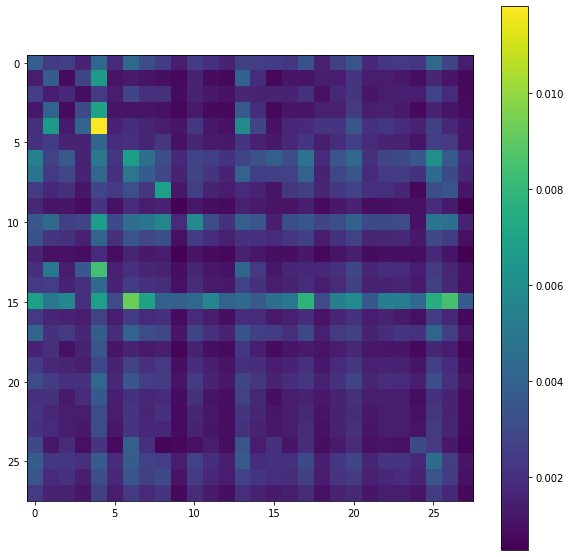

In [19]:
node_lst = [0,  6, 7,  10, 11, 15, 17, 20, 22, 25, 26, 27]
S_cluster = np.loadtxt("/media/gulab/GUDR2/PB10_new/CNR1_29cluster.mtx", dtype=float)
S_cluster_sum = np.sum(S_cluster)
print(np.sum(S_cluster))
fig, ax = plt.subplots(figsize=(10, 10))
pos = ax.imshow(S_cluster)
fig.colorbar(pos, ax=ax)
plt.show()

## load 30d1 communication score matrix and normalization

0.3919092392087706


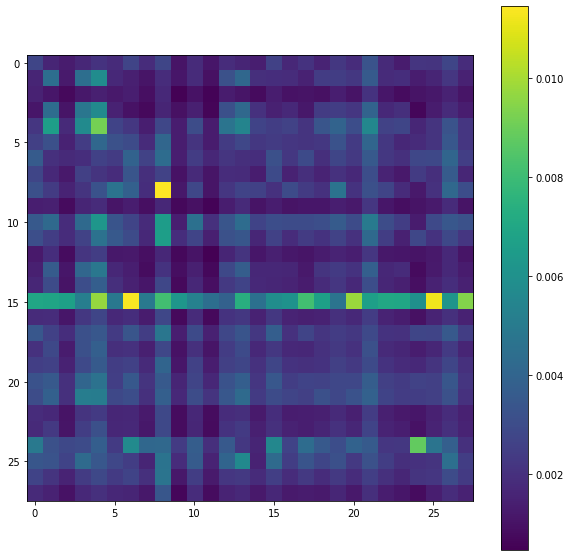

In [20]:
S_cluster_30 = np.loadtxt("/media/gulab/GUDR2/PB10_new/30d1_29cluster.mtx", dtype=float)
tmp_30_sum = sum(S_cluster_30)
sum_30 = 0.0
for item in node_lst:
    sum_30 = sum_30 + tmp_30_sum[item]
print(sum_30)
for i in range(len(S_cluster_30)):
    for j in range(len(S_cluster_30)):
        S_cluster_30[i][j] = S_cluster_30[i][j] * S_sum / sum_30

fig, ax = plt.subplots(figsize=(10, 10))
pos = ax.imshow(S_cluster_30)
fig.colorbar(pos, ax=ax)
plt.show()

## Use cluster size as point size on CNR1

In [21]:
cluster_id = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_CNR1_cluster.csv", dtype=int)
cluster_count_lst = [0] * 13
node_lst = [0, 2, 6, 7, 10, 11, 15, 17, 26, 27, 22, 20, 25]
for i in range(len(cluster_id)):
    for j in range(len(node_lst)):
        if int(cluster_id[i]) - 1 == node_lst[j]:
            cluster_count_lst[j] = cluster_count_lst[j] + 1

In [22]:
cluster_count_lst

[1139, 1323, 564, 555, 326, 254, 161, 1494, 267, 226, 344, 643, 384]

## Use cluster size as point size on 30d1

In [23]:
cluster_id_30 = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_30d1_cluster.csv", dtype=int)
cluster_count_lst_30 = [0] * 13
node_lst = [0, 2, 6, 7, 10, 11, 15, 17, 26, 27, 22, 20, 25]
for i in range(len(cluster_id_30)):
    for j in range(len(node_lst)):
        if int(cluster_id_30[i]) - 1 == node_lst[j]:
            cluster_count_lst_30[j] = cluster_count_lst_30[j] + 1

In [24]:
cluster_count_lst_30

[1058, 651, 422, 318, 237, 169, 56, 1205, 262, 278, 395, 485, 200]

## Communication score plot

0 2 0.5052614678265525
0 6 0.6345666575085115
0 7 0.5877137173458736
0 10 0.7303389436455396
0 11 0.5549860014179244
0 15 1.0370386238963694
0 17 0.6124707895550058
0 20 0.5396359389927992
0 22 0.7769674630841151
0 25 0.49453882846030345
0 26 1.012370926858181
0 27 1.3653815612113827
2 0 0.5892120147564587
2 6 0.48257142983085766
2 7 0.45215808988238254
2 10 0.6423989843511564
2 11 0.43613817344880856
2 15 0.8325906598520819
2 17 0.4880232885255096
2 20 0.47725768955097175
2 22 0.7920674139199124
2 25 0.4126216463295419
2 26 0.8045945178242642
2 27 1.351443527468109
6 0 0.6668152533417191
6 2 0.48216852044755754
6 7 0.5656062479749525
6 10 0.8797335018494074
6 11 0.6598664717938904
6 15 0.8108159709586757
6 17 0.6120012258564058
6 20 0.5457031182214744
6 22 0.7899107488861534
6 25 0.47082867399133954
6 26 1.0885639649281607
6 27 1.381463755672994
7 0 0.5666376430123293
7 2 0.41654660333305366
7 6 0.6820626941325736
7 10 0.6237566468042167
7 11 0.49707538038663907
7 15 1.107328341258866

No handles with labels found to put in legend.


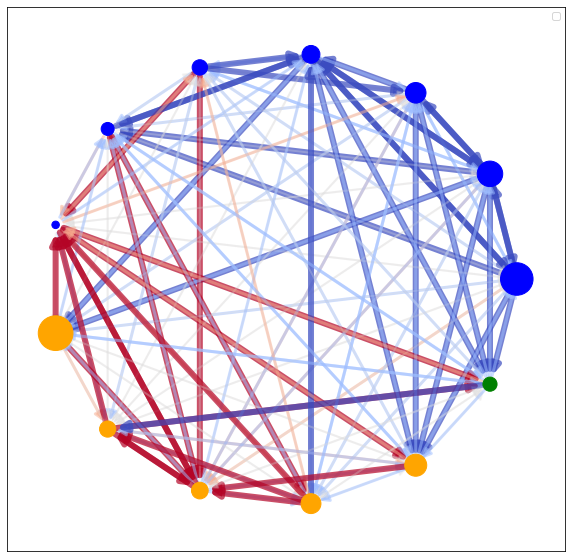

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
G_30 = nx.DiGraph()

r = 5
node_lst = [0, 2, 6, 7, 10, 11, 15, 17, 26, 27, 22, 20, 25]
Neuron_lst = [0, 2, 6, 7, 10, 11, 15]
M_lst = [25]
A_lst = [17, 26, 27, 22, 20]
for i in range(len(node_lst)):
    if node_lst[i] in Neuron_lst:
        G_30.add_node(node_lst[i], color = 'blue', pos = (r*np.cos(i/len(node_lst)*2*np.pi), r*np.sin(2*np.pi*i/len(node_lst))))
    if node_lst[i] in A_lst:
        G_30.add_node(node_lst[i], color = 'orange', pos = (r*np.cos(i/len(node_lst)*2*np.pi), r*np.sin(2*np.pi*i/len(node_lst))))
    if node_lst[i] in M_lst:
        G_30.add_node(node_lst[i], color = 'green', pos = (r*np.cos(i/len(node_lst)*2*np.pi), r*np.sin(2*np.pi*i/len(node_lst))))

colors_30 = []
pair_lst_30 = []
P_value_30 = []
count = 0
                    
for i in range(28):
    if i in node_lst:
        for j in range(28):
            #if j in node_lst and (i not in Neuron_lst or j not in Neuron_lst) and i != j:
            if j in node_lst and i != j:
                print(str(i)+" "+str(j)+" "+str(S_cluster_30[i][j]/S_cluster[i][j]))
                G_30.add_edge(i, j, weight = S_cluster_30[i][j]/S_cluster[i][j])
                colors_30.append(S_cluster_30[i][j]/S_cluster[i][j])
                pair_lst_30.append((i, j))

M_30 = G_30.number_of_edges()
E_30 = G_30.edges()
N_30 = G_30.nodes()
colors_node_30 = [N_30[u]['color'] for u in N_30]
print(M_30)
colors_index_30 = []        
edge_alpha_30 = []
edge_width_30 = []
for i in range(len(colors_30)):
    if colors_30[i] <= 0.6:
        colors_index_30.append(1)
        edge_alpha_30.append(0.7)
        edge_width_30.append(6)
    elif colors_30[i] > 0.6 and colors_30[i] <= 0.8:
        colors_index_30.append(4)
        edge_alpha_30.append(0.5)
        edge_width_30.append(3)
    elif colors_30[i] > 0.8 and colors_30[i] <= 1:
        colors_index_30.append(6)
        edge_alpha_30.append(0.3)
        edge_width_30.append(2)
    elif colors_30[i] > 1 and colors_30[i] <= 1.2:
        colors_index_30.append(6)
        # edge_alpha.append(0.5)
        edge_alpha_30.append(0.3)
        edge_width_30.append(2)
    elif colors_30[i] > 1.2 and colors_30[i] <= 1.4:
        colors_index_30.append(8)
        edge_alpha_30.append(0.5)
        edge_width_30.append(3)
    elif colors_30[i] > 1.4:
        colors_index_30.append(11)
        # edge_alpha.append(0.11)
        edge_alpha_30.append(0.7)
        edge_width_30.append(6)

seed = 121
pos_30 = nx.get_node_attributes(G_30,'pos')

node_size_30 = cluster_count_lst_30
options = {
    "node_color": "black",
    "edge_color": colors_index_30,
    "node_size": cluster_count_lst_30,
    "width": 5,
    "arrowsize": 10,
    "edge_cmap": plt.cm.plasma,
    "with_labels": False,
}
fig, ax = plt.subplots(figsize=(10, 10))
print(colors_index_30)
print(edge_alpha_30)
print(len(G_30))
print(len(pos_30))
nodes_30 = nx.draw_networkx_nodes(G_30, pos_30, 
                               node_color = colors_node_30,
                              node_size = cluster_count_lst_30
                              )
edges_30 = nx.draw_networkx_edges(G_30, pos_30,
    edge_color = colors_index_30,
    width = edge_width_30,
    arrowsize = 18,
    arrowstyle = "-|>",
    edge_cmap = plt.cm.coolwarm)

for i in range(M_30):
    edges_30[i].set_alpha(edge_alpha_30[i])


plt.legend()
# plt.show()        
plt.savefig("/media/gulab/GUDR2/PB10_new/fold.svg")

In [31]:
import numpy as np
from scipy.spatial import distance_matrix
import pandas as pd
import os
import sys
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

from spaotsc import SpaOTsc

df_full = pd.read_csv('/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2Mask30d1_S2CellGeneExp.txt', index_col=0)
x = np.array( df_full.values, float )

print(1)

for i in range(x.shape[0]):
    x[i,:] = x[i,:]/np.sum(x[i,:])*10000.0

    
df_full = pd.DataFrame(data=x, columns=df_full.columns.values, index = df_full.index.values)
x = np.array( df_full.values, float )
x = np.log( 1.0 + x )
df_full = pd.DataFrame(data=x, columns=df_full.columns.values, index = df_full.index.values)
issc_signal = SpaOTsc.spatial_sc(sc_data=df_full)

pts = np.loadtxt("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/pos_30d1.csv", delimiter=',')
dmat_is = distance_matrix(pts, pts)
issc_signal.cell_cell_distance(sc_dmat_spatial=dmat_is/dmat_is.max())
print(2)


ligGene_lst = [['Apoe'], ['Mif'], ['C1qb'], ['Spp1']]
recGene_lst = [['Chrna4','Ldlr','Lrp1', 'Lrp2', 'Lrp5', 'Lrp8', 'Scarb1', 'Sorl1', 'Vldlr'], 
               ['Ackr3','Cd44', 'Cd74','Cxcr2', 'Cxcr4'],
               ['Lrp1'],
               ['Cd44', 'Itga4', 'Itga5', 'Itga9', 'Itgav', 'Itgb1', 'S1pr1']]

cluster_id = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_30d1_cluster.csv", dtype=int)
ics = list(set(cluster_id))

for K in range(len(ligGene_lst)):
    S_calca = issc_signal.spatial_signaling_ot(ligGene_lst[K],recGene_lst[K], rho=0.1, epsilon=0.1)

    S_cluster = np.empty( [28, 28], float )

    for i in range(28):
        for j in range(28):
            icid = np.where(cluster_id==ics[i])[0]
            jcid = np.where(cluster_id==ics[j])[0]
            S_cluster[i,j] = np.mean(S_calca[icid,:][:,jcid])

            L = np.sum(S_calca, axis=1)

    fileobj1 = open('/media/gulab/GUDR2/PB10_new/30d1_'+ligGene_lst[i]+'_S2.csv', mode='wb')
    L.tofile(fileobj1,sep="\n")

KeyboardInterrupt: 

In [ ]:
df_full = pd.read_csv('/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2MaskCNR1_S2CellGeneExp.txt', index_col=0)
x = np.array( df_full.values, float )

print(1)

for i in range(x.shape[0]):
    x[i,:] = x[i,:]/np.sum(x[i,:])*10000.0

    
df_full = pd.DataFrame(data=x, columns=df_full.columns.values, index = df_full.index.values)
x = np.array( df_full.values, float )
x = np.log( 1.0 + x )
df_full = pd.DataFrame(data=x, columns=df_full.columns.values, index = df_full.index.values)
issc_signal = SpaOTsc.spatial_sc(sc_data=df_full)

pts = np.loadtxt("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/pos_CN1.csv", delimiter=',')
dmat_is = distance_matrix(pts, pts)
issc_signal.cell_cell_distance(sc_dmat_spatial=dmat_is/dmat_is.max())
print(2)


ligGene_lst = [['Apoe'], ['Mif'], ['C1qb'], ['Spp1']]
recGene_lst = [['Chrna4','Ldlr','Lrp1', 'Lrp2', 'Lrp5', 'Lrp8', 'Scarb1', 'Sorl1', 'Vldlr'], 
               ['Ackr3','Cd44', 'Cd74','Cxcr2', 'Cxcr4'],
               ['Lrp1'],
               ['Cd44', 'Itga4', 'Itga5', 'Itga9', 'Itgav', 'Itgb1', 'S1pr1']]

cluster_id = np.loadtxt("/media/gulab/GUDR2/PB10_new/S2umap_CNR1_cluster.csv", dtype=int)
ics = list(set(cluster_id))

for K in range(len(ligGene_lst)):
    S_calca = issc_signal.spatial_signaling_ot(ligGene_lst[K],recGene_lst[K], rho=0.1, epsilon=0.1)

    S_cluster = np.empty( [28, 28], float )

    for i in range(28):
        for j in range(28):
            icid = np.where(cluster_id==ics[i])[0]
            jcid = np.where(cluster_id==ics[j])[0]
            S_cluster[i,j] = np.mean(S_calca[icid,:][:,jcid])

            L = np.sum(S_calca, axis=1)

    fileobj1 = open('/media/gulab/GUDR2/PB10_new/CNR1_'+ligGene_lst[i]+'_S2.csv', mode='wb')
    L.tofile(fileobj1,sep="\n")

In [ ]:
S_Mif_30d1_File = open("/media/gulab/GUDR2/PB10_new/30d1_Mif_S2.csv")
S_Mif_30d1_Lines = S_Mif_30d1_File.readlines()
S_lst_Mif_30d1 = []
for i in tqdm(range(len(S_Mif_30d1_Lines))):
    S_lst_Mif_30d1.append(S_Mif_30d1_Lines[i].strip('\n'))

S_Spp1_30d1_File = open("/media/gulab/GUDR2/PB10_new/30d1_Spp1_S2.csv")
S_Spp1_30d1_Lines = S_Spp1_30d1_File.readlines()
S_lst_Spp1_30d1 = []
for i in tqdm(range(len(S_Spp1_30d1_Lines))):
    S_lst_Spp1_30d1.append(S_Spp1_30d1_Lines[i].strip('\n'))

S_C1qb_30d1_File = open("/media/gulab/GUDR2/PB10_new/30d1_C1qb_S2.csv")
S_C1qb_30d1_Lines = S_C1qb_30d1_File.readlines()
S_lst_C1qb_30d1 = []
for i in tqdm(range(len(S_C1qb_30d1_Lines))):
    S_lst_C1qb_30d1.append(S_C1qb_30d1_Lines[i].strip('\n'))

S_all_30d1_File = open("/media/gulab/GUDR2/PB10_new/30d1_28cluster_sender.csv")
S_all_30d1_Lines = S_all_30d1_File.readlines()
S_all_30d1_lst = []
for i in tqdm(range(len(S_all_30d1_Lines))):
    S_all_30d1_lst.append(S_all_30d1_Lines[i].strip('\n'))
    
Sender_Apoe_30d1_File = open("/media/gulab/GUDR2/PB10_new/30d1_Apoe_S2.csv")
Sender_Apoe_30d1_Lines = Sender_Apoe_30d1_File.readlines()
Sender_lst_Apode_30d1 = []
for i in tqdm(range(len(Sender_Apoe_30d1_Lines))):
    Sender_lst_Apode_30d1.append(Sender_Apoe_30d1_Lines[i].strip('\n'))

In [ ]:
Sender_Apoe_CNR1_File = open("/media/gulab/GUDR2/PB10_new/CNR1_Apoe_S2.csv")
Sender_Apoe_CNR1_Lines = Sender_Apoe_CNR1_File.readlines()
Sender_lst_Apode_CNR1 = []
for i in tqdm(range(len(Sender_Apoe_CNR1_Lines))):
    Sender_lst_Apode_CNR1.append(Sender_Apoe_CNR1_Lines[i].strip('\n'))
    
S_Mif_CNR1_File = open("/media/gulab/GUDR2/PB10_new/CNR1_Mif_S2.csv")
S_Mif_CNR1_Lines = S_Mif_CNR1_File.readlines()
S_lst_Mif_CNR1 = []
for i in tqdm(range(len(S_Mif_CNR1_Lines))):
    S_lst_Mif_CNR1.append(S_Mif_CNR1_Lines[i].strip('\n'))

S_Spp1_CNR1_File = open("/media/gulab/GUDR2/PB10_new/CNR1_Spp1_S2.csv")
S_Spp1_CNR1_Lines = S_Spp1_CNR1_File.readlines()
S_lst_Spp1_CNR1 = []
for i in tqdm(range(len(S_Spp1_CNR1_Lines))):
    S_lst_Spp1_CNR1.append(S_Spp1_CNR1_Lines[i].strip('\n'))

S_C1qb_CNR1_File = open("/media/gulab/GUDR2/PB10_new/CNR1_C1qb_S2.csv")
S_C1qb_CNR1_Lines = S_C1qb_CNR1_File.readlines()
S_lst_C1qb_CNR1 = []
for i in tqdm(range(len(S_C1qb_CNR1_Lines))):
    S_lst_C1qb_CNR1.append(S_C1qb_CNR1_Lines[i].strip('\n'))

S_all_CNR1_File = open("/media/gulab/GUDR2/PB10_new/CNR1_28cluster_sender.csv")
S_all_CNR1_Lines = S_all_CNR1_File.readlines()
S_all_CNR1_lst = []
for i in tqdm(range(len(S_all_CNR1_Lines))):
    S_all_CNR1_lst.append(S_all_CNR1_Lines[i].strip('\n'))

In [ ]:
Coord_30d1_File = open("/media/gulab/GUDR2/PB10_new/30d1_coord.csv")
Coord_30d1_Lines = Coord_30d1_File.readlines()
Coord_30d1_Barcode_lst = []
Coord_30d1_X_lst = []
Coord_30d1_Y_lst = []
for i in tqdm(range(1, len(Coord_30d1_Lines))):
    tmp_lst = Coord_30d1_Lines[i].strip('\n').split(',')
    Coord_30d1_Barcode_lst.append(tmp_lst[3])
    Coord_30d1_X_lst.append(tmp_lst[1])
    Coord_30d1_Y_lst.append(tmp_lst[2])

In [ ]:
Coord_CNR1_File = open("/media/gulab/GUDR2/PB10_new/CNR1_coord.csv")
Coord_CNR1_Lines = Coord_CNR1_File.readlines()
Coord_CNR1_Barcode_lst = []
Coord_CNR1_X_lst = []
Coord_CNR1_Y_lst = []
for i in tqdm(range(1, len(Coord_CNR1_Lines))):
    tmp_lst = Coord_CNR1_Lines[i].strip('\n').split(',')
    Coord_CNR1_Barcode_lst.append(tmp_lst[3])
    Coord_CNR1_X_lst.append(tmp_lst[1])
    Coord_CNR1_Y_lst.append(tmp_lst[2])

In [ ]:
Hash_B2ApoeS = {}
for i in range(len(Coord_CNR1_Barcode_lst)):
    Hash_B2ApoeS[Coord_CNR1_Barcode_lst[i]] = Sender_lst_Apode_CNR1[i]
for i in range(len(Coord_30d1_Barcode_lst)):
    Hash_B2ApoeS[Coord_30d1_Barcode_lst[i]] = Sender_lst_Apode_30d1[i]

Hash_B2MifS = {}
for i in range(len(Coord_CNR1_Barcode_lst)):
    Hash_B2MifS[Coord_CNR1_Barcode_lst[i]] = S_lst_Mif_CNR1[i]
for i in range(len(Coord_30d1_Barcode_lst)):
    Hash_B2MifS[Coord_30d1_Barcode_lst[i]] = S_lst_Mif_30d1[i]

Hash_B2Spp1S = {}
for i in range(len(Coord_CNR1_Barcode_lst)):
    Hash_B2Spp1S[Coord_CNR1_Barcode_lst[i]] = S_lst_Spp1_CNR1[i]
for i in range(len(Coord_30d1_Barcode_lst)):
    Hash_B2Spp1S[Coord_30d1_Barcode_lst[i]] = S_lst_Spp1_30d1[i]
    
Hash_B2C1qbS = {}
for i in range(len(Coord_CNR1_Barcode_lst)):
    Hash_B2C1qbS[Coord_CNR1_Barcode_lst[i]] = S_lst_C1qb_CNR1[i]
for i in range(len(Coord_30d1_Barcode_lst)):
    Hash_B2C1qbS[Coord_30d1_Barcode_lst[i]] = S_lst_C1qb_30d1[i]

Hash_B2PAllS = {}
for i in range(len(Coord_CNR1_Barcode_lst)):
    Hash_B2PAllS[Coord_CNR1_Barcode_lst[i]] = S_all_CNR1_lst[i]
for i in range(len(Coord_30d1_Barcode_lst)):
    Hash_B2PAllS[Coord_30d1_Barcode_lst[i]] = S_all_30d1_lst[i]


In [ ]:
from tqdm import tqdm
All_barcode_coord_File = open("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2Mask30d1_S2CellGeneExp.txt")
All_barcode_coord_Lines = All_barcode_coord_File.readlines()
cluster_index_File = open("/media/gulab/GUDR2/PB10_new/S2umap_30d1_cluster.csv")
cluster_index_Lines = cluster_index_File.readlines()
dict_B2C = {}
cluster_lst = []
for i in tqdm(range(len(cluster_index_Lines))):
    cluster_lst.append(cluster_index_Lines[i].strip('\n'))
Barcode_lst = []
for i in tqdm(range(1, len(All_barcode_coord_Lines))):
    tmp_lst = All_barcode_coord_Lines[i].strip('\n').split(',')
    Barcode_lst.append(tmp_lst[0])
for i in tqdm(range(len(Barcode_lst))):
    Barcode_lst[i] = "30d1_S2_" + Barcode_lst[i]
    dict_B2C[Barcode_lst[i]] = cluster_lst[i]
    
All_barcode_coord_File = open("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2MaskCNR1_S2CellGeneExp.txt")
All_barcode_coord_Lines = All_barcode_coord_File.readlines()
cluster_index_File = open("/media/gulab/GUDR2/PB10_new/S2umap_CNR1_cluster.csv")
cluster_index_Lines = cluster_index_File.readlines()

cluster_lst = []
for i in tqdm(range(len(cluster_index_Lines))):
    cluster_lst.append(cluster_index_Lines[i].strip('\n'))
Barcode_lst = []
for i in tqdm(range(1, len(All_barcode_coord_Lines))):
    tmp_lst = All_barcode_coord_Lines[i].strip('\n').split(',')
    Barcode_lst.append(tmp_lst[0])
for i in tqdm(range(len(Barcode_lst))):
    Barcode_lst[i] = "CNR1_S2_" + Barcode_lst[i]
    dict_B2C[Barcode_lst[i]] = cluster_lst[i]

In [ ]:
Coord_30d1_Barcode_clean_lst = []
S_Apoe_30d1_lst = []
S_Mif_30d1_lst = []
S_Spp1_30d1_lst = []
S_C1qb_30d1_lst = []
cluster_30d1_lst = []
Coord_30d1_X_clean_lst = []
Coord_30d1_Y_clean_lst = []
S_all_30d1_lst = []
count = 0

for i in tqdm(range(len(Coord_30d1_Barcode_lst))):
    if Coord_30d1_Barcode_lst[i] in dict_B2C.keys():
        Coord_30d1_X_clean_lst.append(Coord_30d1_X_lst[i])
        Coord_30d1_Y_clean_lst.append(Coord_30d1_Y_lst[i])
        S_Apoe_30d1_lst.append(Hash_B2ApoeS[Coord_30d1_Barcode_lst[i]])
        S_Mif_30d1_lst.append(Hash_B2MifS[Coord_30d1_Barcode_lst[i]])
        S_Spp1_30d1_lst.append(Hash_B2Spp1S[Coord_30d1_Barcode_lst[i]])
        S_C1qb_30d1_lst.append(Hash_B2C1qbS[Coord_30d1_Barcode_lst[i]])
        cluster_30d1_lst.append(dict_B2C[Coord_30d1_Barcode_lst[i]])
        Coord_30d1_Barcode_clean_lst.append(Coord_30d1_Barcode_lst[i])
        S_all_30d1_lst.append(Hash_B2PAllS[Coord_30d1_Barcode_lst[i]])
    else:
        count = count + 1
print(count)

In [ ]:
Coord_CNR1_Barcode_clean_lst = []
S_Apoe_CNR1_lst = []
S_Mif_CNR1_lst = []
S_Spp1_CNR1_lst = []
S_C1qb_CNR1_lst = []
cluster_CNR1_lst = []
Coord_CNR1_X_clean_lst = []
Coord_CNR1_Y_clean_lst = []
S_all_CNR1_lst = []
count = 0

for i in tqdm(range(len(Coord_CNR1_Barcode_lst))):
    if Coord_CNR1_Barcode_lst[i] in dict_B2C.keys():
        Coord_CNR1_X_clean_lst.append(Coord_CNR1_X_lst[i])
        Coord_CNR1_Y_clean_lst.append(Coord_CNR1_Y_lst[i])
        S_Apoe_CNR1_lst.append(Hash_B2ApoeS[Coord_CNR1_Barcode_lst[i]])
        S_Mif_CNR1_lst.append(Hash_B2MifS[Coord_CNR1_Barcode_lst[i]])
        S_Spp1_CNR1_lst.append(Hash_B2Spp1S[Coord_CNR1_Barcode_lst[i]])
        S_C1qb_CNR1_lst.append(Hash_B2C1qbS[Coord_CNR1_Barcode_lst[i]])
        cluster_CNR1_lst.append(dict_B2C[Coord_CNR1_Barcode_lst[i]])
        Coord_CNR1_Barcode_clean_lst.append(Coord_CNR1_Barcode_lst[i])
        S_all_CNR1_lst.append(Hash_B2PAllS[Coord_CNR1_Barcode_lst[i]])
    else:
        count = count + 1
print(count)

In [ ]:
selected_30d1_File = open("/media/gulab/GUDR2/PB10_new/Coord_30d1_clean.csv", "w")
selected_30d1_File.write("CoordX\tCoordY\tcluster\tBarcode\tSApoe\tSMif\tSSpp1\tSC1qb\tSall\n")
for i in range(len(Coord_30d1_Barcode_clean_lst)):
    selected_30d1_File.write(str(Coord_30d1_X_clean_lst[i])+"\t"+str(Coord_30d1_Y_clean_lst[i])+"\t"+str(cluster_30d1_lst[i])+"\t"+str(Coord_30d1_Barcode_clean_lst[i])+"\t"+str(S_Apoe_30d1_lst[i])+"\t"+str(S_Mif_30d1_lst[i])+"\t"+str(S_Spp1_30d1_lst[i])+"\t"+str(S_C1qb_30d1_lst[i])+"\t"+str(S_all_30d1_lst[i])+"\n")
selected_30d1_File.close()

In [ ]:
selected_CNR1_File = open("/media/gulab/GUDR2/PB10_new/Coord_CNR1_clean.csv", "w")
selected_CNR1_File.write("CoordX\tCoordY\tcluster\tBarcode\tSApoe\tSMif\tSSpp1\tSC1qb\tSall\n")
for i in range(len(Coord_CNR1_Barcode_clean_lst)):
    selected_CNR1_File.write(str(Coord_CNR1_X_clean_lst[i])+"\t"+str(Coord_CNR1_Y_clean_lst[i])+"\t"+str(cluster_CNR1_lst[i])+"\t"+str(Coord_CNR1_Barcode_clean_lst[i])+"\t"+str(S_Apoe_CNR1_lst[i])+"\t"+str(S_Mif_CNR1_lst[i])+"\t"+str(S_Spp1_CNR1_lst[i])+"\t"+str(S_C1qb_CNR1_lst[i])+"\t"+str(S_all_CNR1_lst[i])+"\n")
selected_CNR1_File.close()